In [8]:
#Supress Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

from psa_main import get_stock_data,predictors
import yfinance as yf
from datetime import datetime,timedelta
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
import pandas_market_calendars as mcal
from scipy import stats
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
plt.rcParams.update({'font.size':20})

#Concatenate all the validation files
files = sorted(glob('backtest_output/*'))
pc = pd.concat([pd.read_csv(f) for f in files])
pc.dropna(inplace=True)
pc.drop(columns='Unnamed: 0',inplace=True)
pc.reset_index(inplace=True,drop=True)


This python notebook uses PCA decomposition to group previous output into 4 categories (i.e., bear, slight bear, bull or slight bull) for 10 trading days after the date of initialization, hence a time series for each stock symbol that was projected to move up significantly. Alebit, not all stocks move up significantly, so lets try to decompose the signals from the previous output here. **There is no limit to how much data can go into this.**

After all of the stock symbol time series have been assigned a mode (0-3), we can take real-time output and produce probabilties as to where the stock symbol in question falls relative to either mode (0-3) based on its current time series within the 10-day time frame. Let's take a look at this:


In [9]:
#Some functions to give us the data we want to look at

def produce_prob(time_series,mode0,mode1,mode2,mode3):
    #Get mean and STD of all clusters
    means0,stds0 = np.nanmean(np.array(mode0),axis=0),np.nanstd(np.array(mode0),axis=0)
    means1,stds1 = np.nanmean(np.array(mode1),axis=0),np.nanstd(np.array(mode1),axis=0)
    means2,stds2 = np.nanmean(np.array(mode2),axis=0),np.nanstd(np.array(mode2),axis=0)
    means3,stds3 = np.nanmean(np.array(mode3),axis=0),np.nanstd(np.array(mode3),axis=0)

    #Compute the zscore for each individual data point
    idx = len(time_series)
    zscore0 = (time_series-means0[:idx])/stds0[:idx]
    zscore1 = (time_series-means1[:idx])/stds1[:idx]
    zscore2 = (time_series-means2[:idx])/stds2[:idx]
    zscore3 = (time_series-means3[:idx])/stds3[:idx]

    #Compute the P values
    pval = np.zeros((4,len(time_series)))*np.nan #[mode,time series]

    
    pval[0,:] = stats.norm.sf(abs(zscore0))*2
    pval[1,:] = stats.norm.sf(abs(zscore1))*2
    pval[2,:] = stats.norm.sf(abs(zscore2))*2
    pval[3,:] = stats.norm.sf(abs(zscore3))*2

    #Return the probabilties of each cluster for each data point in the time series
    return (pval / np.sum(pval,axis=0))

def get_stock_data_probs(tval,forecast_days,lag_val,date_init,date_final_init,current_date=datetime.now()):
    '''Current date can be set as a backtesting technique if desired.'''

    date_final = datetime.strptime(date_final_init,'%Y-%m-%d') + timedelta(days=10)
    if date_final>=current_date:
        print('Validation date goes into the future! Use closest trading date prior to {}'.format((date_final-timedelta(days=11)).strftime('%Y-%m-%d')))
        return
    else:
        cal = mcal.get_calendar('NYSE').schedule(start_date=date_init,end_date=date_final)
        trading_date = pd.to_datetime(mcal.date_range(cal, frequency='1D'))
        days = np.array([datetime(val.year,val.month,val.day).strftime('%Y-%m-%d') for val in trading_date])

        #Create arrays to be returned (validation period lasts 10 days for probability time series)
        pred_day,tot_pred = np.zeros((len(days),10))*np.nan,np.zeros((len(days)))*np.nan

        #Work with the percent change relative to the initial price - compute once
        data = (((pc[['Close{}'.format(i) for i in range(10)]] - pc['price_init'].values[:,None])) / pc['price_init'].values[:,None])
        #Remove outliers
        data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].values


        #Make an array of validation days
        pred_days = days[forecast_days:]
        pred_days = np.array([datetime.strptime(val,'%Y-%m-%d') for val in pred_days])
        try:
            pred_days = pred_days[:np.where(pred_days==datetime.strptime(date_final_init,'%Y-%m-%d'))[0][0]+1]

            #Make an array of input days
            days = np.array([datetime.strptime(val,'%Y-%m-%d') for val in days])
            days = days[:np.where(days==datetime.strptime(date_final_init,'%Y-%m-%d'))[0][0]+1]
        except IndexError:
            print('End Date is not a trading date!')
            return


    #Get the stock's data in bulk to save computing power
    cal = mcal.get_calendar('NYSE').schedule(start_date=datetime.strptime(date_init,'%Y-%m-%d')-timedelta(days=(365*(lag_val*2))), end_date=datetime.strptime(date_final_init,'%Y-%m-%d')+timedelta(days=forecast_days+20))
    date_list = pd.to_datetime(mcal.date_range(cal, frequency='1D'))
    date_list = np.array([datetime(val.year,val.month,val.day) for val in date_list])

    #Grab the bulk data
    df = yf.download(tval,start=date_list[0],end=date_list[-1],interval='1d',progress=False)
    df.reset_index(inplace=True)
    df['Date'] = np.array([pd.to_datetime(val) for val in df['Date'].values])


    #Get the actual observation (list of validation dataframes; up to 10 days out)
    d_true = []
    df_dates = np.array([datetime(pd.to_datetime(val).year,pd.to_datetime(val).month,pd.to_datetime(val).day) for val in df.Date.values])
    for i in range(len(pred_days)):
        idate = np.where(df_dates==pred_days[i])[0][0]
        df_temp = df.loc[idate:idate+9]
        df_temp.reset_index(inplace=True,drop=True)
        d_true.append(df_temp)

    #Get the training dataset (going back lag_years)
    d_train = []
    for i in range(len(days)-1): #remove final day because there is no validation on it, no big deal
        idate = np.where(df_dates==days[i])[0][0]
        df_temp = df.loc[i:idate]
        df_temp.reset_index(inplace=True,drop=True)
        d_train.append(df_temp)


    return d_train,d_true,days[:-1]


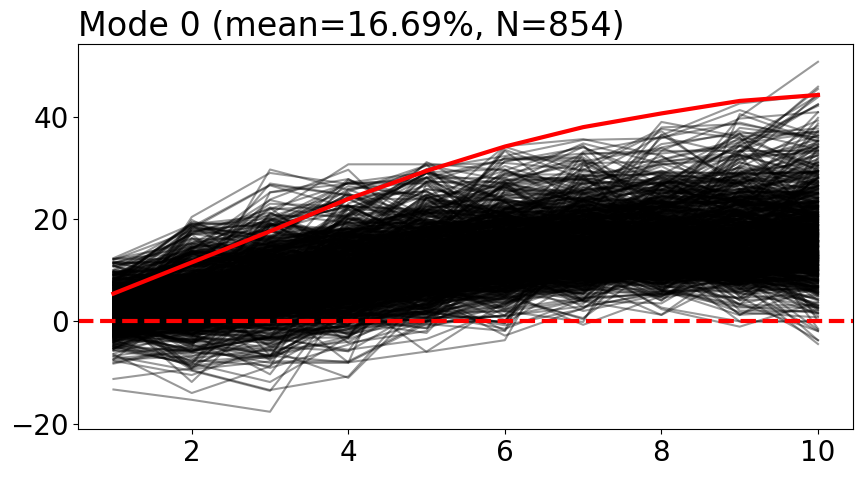

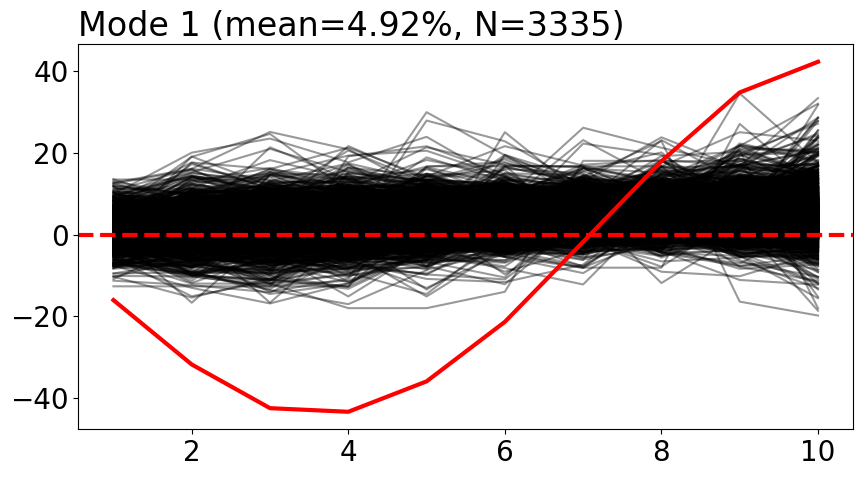

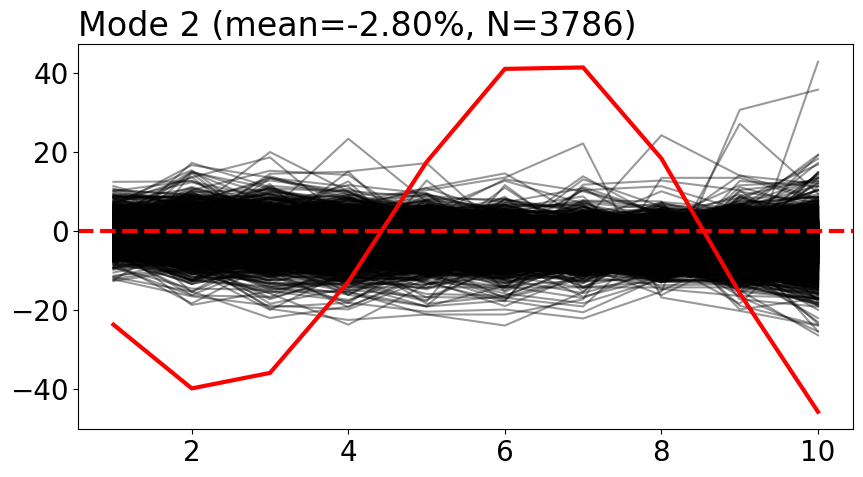

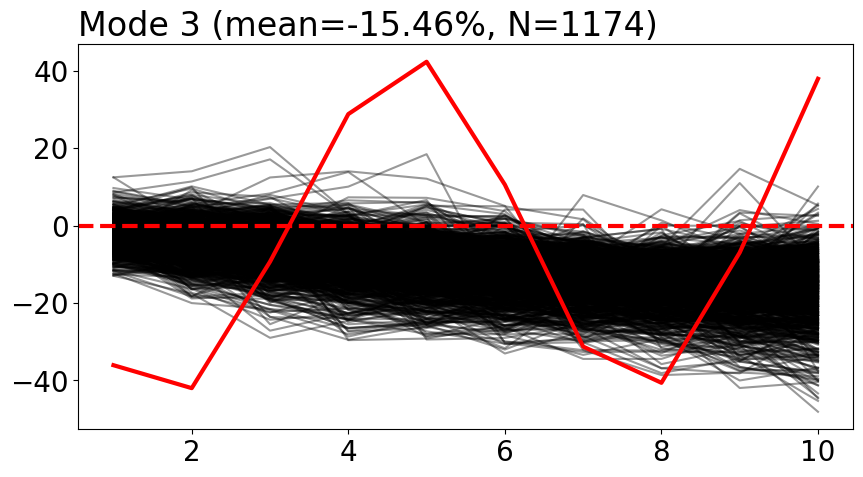

In [10]:
#Plot the first 4 modes of the PCA decomposition (group them by bear, slight bear, bull, and slight bull signals)
#These are plotted for 10 trading days after initialization. 
#Set plot=True to see all the time series data that make up each mode. The solid red line in the plots indicate the 
#PCA mode time series, this does not mean anything.

plot = True
files = sorted(glob('backtest_output/*'))
d = pd.concat([pd.read_csv(f) for f in files])
d.dropna(inplace=True)
d.drop(columns='Unnamed: 0',inplace=True)
d.reset_index(inplace=True,drop=True)

#Get the intial price
init = d['price_init']

d.drop(columns=['symbol', 'price_init', 'pred_price', 'pred_pct', 'obs_price',
       'obs_pct', 'highest_price', 'highest_pct', 'highest_pct_day', 'bool'],inplace=True)

data = (((d[['Close{}'.format(i) for i in range(10)]] - init.values[:,None])) / init.values[:,None])

#Remove outliers
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].values

#Perform a PCA
n_comp = 4
pca = PCA(n_components=n_comp)
pca.fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_comp, n_init=1)

#Group the dataset into these clusters RSS = sum((mode-case)^2)
mode0,mode1,mode2,mode3 = [],[],[],[]
mode_fit = kmeans.fit_predict(data)
for i in range(data.shape[0]):
    mode = mode_fit[i]
    if mode == 0:
        mode0.append(data[i])
    if mode == 1:
        mode1.append(data[i])
    if mode== 2:
        mode2.append(data[i])
    if mode == 3:
        mode3.append(data[i])

if plot == True:
    plt.figure(figsize=(10,5))
    plt.title('Mode 0 (mean={:.2f}%, N={:.0f})'.format(np.nanmean(np.array(mode0)[:,-1])*100,len(mode0)),loc='left')
    [plt.plot(np.arange(1,11),mode0[i]*100,color='k',alpha=0.4) for i in range(len(mode0))]
    plt.plot(np.arange(1,11),pca.components_[0]*100,color='red',linewidth=3)
    plt.axhline(y=0,color='red',linestyle='dashed',linewidth=3)
    plt.show()
    plt.close()

    plt.figure(figsize=(10,5))
    plt.title('Mode 1 (mean={:.2f}%, N={:.0f})'.format(np.nanmean(np.array(mode1)[:,-1])*100,len(mode1)),loc='left')
    [plt.plot(np.arange(1,11),mode1[i]*100,color='k',alpha=0.4) for i in range(len(mode1))]
    plt.plot(np.arange(1,11),pca.components_[1]*100,color='red',linewidth=3)
    plt.axhline(y=0,color='red',linestyle='dashed',linewidth=3)
    plt.show()
    plt.close()

    plt.figure(figsize=(10,5))
    plt.title('Mode 2 (mean={:.2f}%, N={:.0f})'.format(np.nanmean(np.array(mode2)[:,-1])*100,len(mode2)),loc='left')
    [plt.plot(np.arange(1,11),mode2[i]*100,color='k',alpha=0.4) for i in range(len(mode2))]
    plt.plot(np.arange(1,11),pca.components_[2]*100,color='red',linewidth=3)
    plt.axhline(y=0,color='red',linestyle='dashed',linewidth=3)
    plt.show()
    plt.close()

    plt.figure(figsize=(10,5))
    plt.title('Mode 3 (mean={:.2f}%, N={:.0f})'.format(np.nanmean(np.array(mode3)[:,-1])*100,len(mode3)),loc='left')
    [plt.plot(np.arange(1,11),mode3[i]*100,color='k',alpha=0.4) for i in range(len(mode3))]
    plt.plot(np.arange(1,11),pca.components_[3]*100,color='red',linewidth=3)
    plt.axhline(y=0,color='red',linestyle='dashed',linewidth=3)
    plt.show()
    plt.close()
    
else:
    print('Mean percent change at day 10 relative to initial price:\n')
    print('Mode 0: {:.2f}%'.format(np.nanmean(np.array(mode0)[:,-1])*100))
    print('Mode 1: {:.2f}%'.format(np.nanmean(np.array(mode1)[:,-1])*100))
    print('Mode 2: {:.2f}%'.format(np.nanmean(np.array(mode2)[:,-1])*100))
    print('Mode 3: {:.2f}%'.format(np.nanmean(np.array(mode3)[:,-1])*100))


Now that the modes have been established, let's see if we can isolate a stock symbol of choice to see how well the probability of this stock being in either a bear or bull mode was correct on each day of the 10-day time series. If the backtesting data is more or less than what is default, the meaning of the modes might have changed. In the default, mode 0 represents a bull signal (mean=16.69%) and mode 3 represents a bear signal (mean=-15.46%). In the following cell, you must change acc0 and acc3 variables to the mode that represents a bull and bear, respectively (either 0,1,2,3).

What we are about to do now is essentially predict the mode of a stock of choice by using probabilities for the current real-time time series. If the highest probability on day 0, for instance, is a bear signal, how often did that time series end up being a bear signal after the 10 days have elapsed? This plot will show the accuracy for bear and bull signals having the highest probability relative to the day of the time series. In reality, by the 9th day, the mode correpsonding to the highest probability will most often be the mode that this time series gets assigned to in the end. 

This is another predictive tool. Let's dive in:



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3246/3246 [00:52<00:00, 61.88it/s]


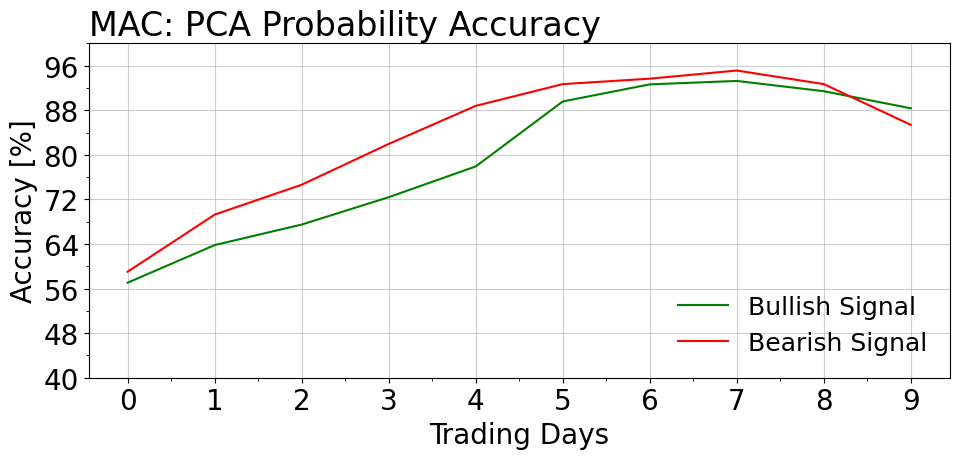

Bull Sample Size: 163
Bear Sample Size: 205


In [11]:
#Find the minimum lag in which the probability time series is most correct (i.e., converges)
tval = 'MAC'
forecast_days = 1 #Trading days to predict into the future
lag_val = 8 #years to go back to train

#List of dates to test
date_init = '2010-01-01'
date_final_init = '2022-11-23' #8 trading days behind the current date (play around with it and see what works)

df,d_true,days = get_stock_data_probs(tval,forecast_days,lag_val,date_init,date_final_init)

#Loop through each trading day
pred_day,mode_pred = np.zeros((len(days),10))*np.nan,np.zeros((len(days)))*np.nan
for count,day in tqdm(enumerate(days),total=len(days)):
    try:
        
        #Subset the stock's dataframe to use only the data for the day being looped through
        
        #Compute probabiities for the time series in question
        time_series = (d_true[count]['Close'].values - df[count]['Close'].values[-1]) /  df[count]['Close'].values[-1]
        prob = produce_prob(time_series,mode0,mode1,mode2,mode3)

        for x in range(10):
            pred_day[count,x] = prob[:,x].argmax()
        mode_pred[count] = kmeans.predict(time_series.reshape(1,-1))
            
    except IndexError:
        #Remove nans if not finished
        pred_day = pred_day[~np.isnan(tot_pred)]
        mode_pred = mode_pred[~np.isnan(tot_pred)]
        break

#Show which trading day is the most accurate for this stock
pred_day = pred_day.T

#Show which trading day is the most accurate for this stock (mode0=bull, mode3=bear)
try:
    acc0 = np.array([np.where((mode_pred==0)&(pred_day[x,:]==0))[0].size / np.where(mode_pred==0)[0].size for x in range(pred_day.shape[0])])
    acc3 = np.array([np.where((mode_pred==3)&(pred_day[x,:]==3))[0].size / np.where(mode_pred==3)[0].size for x in range(pred_day.shape[0])])

    #Plot the figure
    plt.figure(figsize=(10,5))
    plt.grid(alpha=0.6)
    ax = plt.subplot(1,1,1)
    plt.title('{}: PCA Probability Accuracy'.format(tval),loc='left')
    ax.plot(np.arange(10),acc0*100,color='green',label='Bullish Signal')
    ax.plot(np.arange(10),acc3*100,color='red',label='Bearish Signal')
    plt.legend(loc='lower right',framealpha=0,fontsize=18)

    ax.set_xlabel('Trading Days')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))

    ax.set_ylabel('Accuracy [%]')
    ax.yaxis.set_major_locator(MultipleLocator(8))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(MultipleLocator(4))
    ax.set_ylim([40,100])

    plt.tight_layout()
    plt.show()
    plt.close()
    
    print('Bull Sample Size: {:.0f}'.format(np.where(mode_pred==0)[0].size))
    print('Bear Sample Size: {:.0f}'.format(np.where(mode_pred==3)[0].size))
except ZeroDivisionError:
    print('Stock does not have buy or sell signals')
    



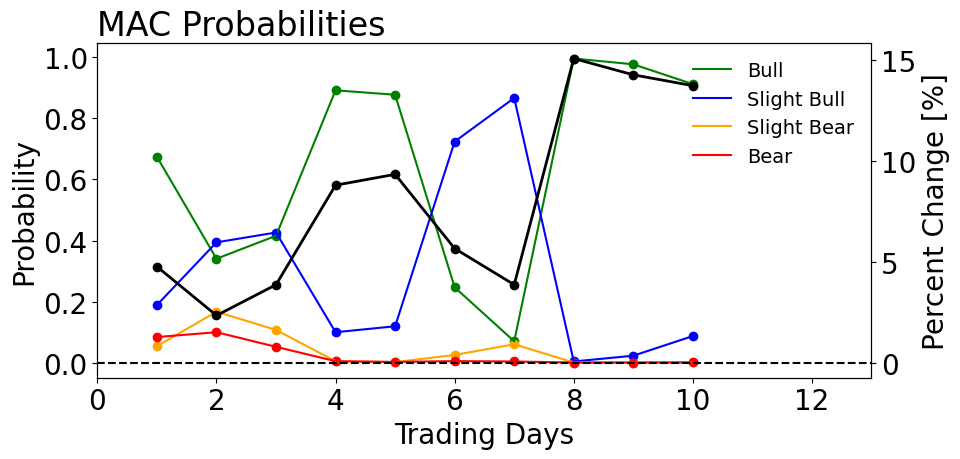

In [12]:
#Make the actual PCA probability predictions
date_init = '2022-11-01'
cal = mcal.get_calendar('NYSE').schedule(start_date=date_init,end_date=date_init)
trading_date = pd.to_datetime(mcal.date_range(cal, frequency='1D'))
day = np.array([datetime(val.year,val.month,val.day).strftime('%Y-%m-%d') for val in trading_date])[0]

#Get the dataset
df,d_true = get_stock_data(day,tval,lag_val,forecast_days,tick_list=False)

#Compute probabiities for the time series in question
time_series = (d_true['Close'].values - df['Close'].values[-1]) /  df['Close'].values[-1]
prob = produce_prob(time_series,mode0,mode1,mode2,mode3)

plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
plt.title('{} Probabilities'.format(tval),loc='left')

ax.plot(np.arange(1,len(time_series)+1),prob[0,:],color='green',label='Bull')
ax.scatter(np.arange(1,len(time_series)+1),prob[0,:],color='green')

ax.plot(np.arange(1,len(time_series)+1),prob[1,:],color='blue',label='Slight Bull')
ax.scatter(np.arange(1,len(time_series)+1),prob[1,:],color='blue')

ax.plot(np.arange(1,len(time_series)+1),prob[2,:],color='orange',label='Slight Bear')
ax.scatter(np.arange(1,len(time_series)+1),prob[2,:],color='orange')

ax.plot(np.arange(1,len(time_series)+1),prob[3,:],color='red',label='Bear')
ax.scatter(np.arange(1,len(time_series)+1),prob[3,:],color='red')

ax.legend(loc='upper right',framealpha=0,fontsize=14)

ax.set_xlabel('Trading Days')
ax.set_ylabel('Probability')
ax.set_xlim([0,13])

ax1 = ax.twinx()
ax1.plot(np.arange(1,len(time_series)+1),time_series*100,color='k',linewidth=2)
ax1.scatter(np.arange(1,len(time_series)+1),time_series*100,color='k')
ax1.axhline(y=0,color='k',linestyle='dashed')
ax1.set_ylabel('Percent Change [%]') #Percent change relative to initial price at the start of the time series

plt.tight_layout()
plt.show()
plt.close()
